In [ ]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

: 

In [ ]:
# curr_dir = os.path.dirname(os.path.abspath(__file__))
#parent_dir = os.path.dirname(curr_dir)
#sys.path.append(parent_dir)

file_path = "../data/external/maze_data.hdf5"

# ---------------- VARIABLES TO STORE
all_actions = []
all_observations = []
all_rewards_to_go = []
all_time_to_go = []
# -----------------------------------

with h5py.File(file_path, "r+") as f:
    for key in f.keys():
        #del episode_87["key-id"] removing a thing
        
        curr_episode = f[key]

        # split observations into the useful and useless observations (1 more observation than action) if not done before
        if "removed_last_obervation" not in curr_episode.keys():
            curr_episode["removed_last_obervation"] = curr_episode["observations"][-1]
            curr_episode["observations_data"] = curr_episode["observations"][:-1]

        # Inspect data in each attribute
        actions = curr_episode["actions"][:]
        infos = curr_episode["infos"]
        observations = curr_episode["observations_data"][:]
        rewards = curr_episode["rewards"][:]
        terminations = curr_episode["terminations"][:]
        truncations = curr_episode["truncations"][:]

        reward_sum = np.sum(rewards)
        rewards_to_go = np.zeros_like(rewards)  # desired reward
        time_to_go = np.zeros_like(rewards)  # desired horizon
        for i in range (len(rewards)):
            rewards_to_go[i] = reward_sum
            reward_sum -= rewards[i]
            time_to_go[i] = len(rewards) - i
        # save the rewards as labels
        
        if "rewards_to_go" not in curr_episode.keys():
            curr_episode["rewards_to_go"] = rewards_to_go
            curr_episode["time_to_go"] = time_to_go

        # save the stuff
        all_actions.append(actions)
        all_observations.append(observations)
        all_rewards_to_go.append(rewards_to_go)
        all_time_to_go.append(time_to_go)
        

    print(rewards[-5:], rewards_to_go[-5:], time_to_go[-5:])
    # Dimensions:
    print(f"Keys in {key}:", list(curr_episode.keys()))
    print(f"{key} Action dimensions: {actions.shape}")
    print(f"Observation dimensions: {observations.shape}")
    print(f"Reward dimensions: {rewards.shape}")
    print(f"Termination dimensions: {terminations.shape}")
    print(f"Truncation dimensions: {truncations.shape}")

[4.53705551 4.75870536 5.20804495 5.30901434 4.93248319] [24.74530334 20.20824784 15.44954248 10.24149753  4.93248319] [5. 4. 3. 2. 1.]
Keys in episode_999: ['actions', 'infos', 'observations', 'observations_data', 'removed_last_obervation', 'rewards', 'rewards_to_go', 'terminations', 'time_to_go', 'truncations']
episode_999 Action dimensions: (1000, 8)
Observation dimensions: (1000, 105)
Reward dimensions: (1000,)
Termination dimensions: (1000,)
Truncation dimensions: (1000,)


In [3]:
print(len(all_actions))

1078


In [3]:
#store the rewards_to_go in a seperate array for data analysis
rewards_to_go_list = all_rewards_to_go[:]

# Creating the concatenated dataset

In [4]:
# combine the data into single vectors
all_actions_list = np.concatenate(all_actions, axis=0)
all_observations_list = np.concatenate(all_observations, axis=0)
all_rewards_to_go_list = np.concatenate(all_rewards_to_go, axis=0)
all_time_to_go_list = np.concatenate(all_time_to_go, axis=0)

## Data augmentation

In [13]:
duplicates=18
reward_range=(-400, 200)
min_horizon=100

In [14]:
# 1. Filter: d_r in reward_range and d_h > min_horizon
mask = (
    (all_rewards_to_go_list >= reward_range[0])
    & (all_rewards_to_go_list <= reward_range[1])
    & (all_time_to_go_list > min_horizon)
)
indices = np.where(mask)[0]

if len(indices) == 0:
    print("No samples found in specified d_r/d_h region. Nothing to augment.")
else: 
    print(f"Found {len(indices)} samples in specified d_r/d_h region.")

Found 29174 samples in specified d_r/d_h region.


In [15]:
dup_actions = np.repeat(all_actions_list[indices], duplicates, axis=0)
dup_observations = np.repeat(all_observations_list[indices], duplicates, axis=0)
dup_rewards_to_go = np.repeat(all_rewards_to_go_list[indices], duplicates, axis=0)
dup_time_to_go = np.repeat(all_time_to_go_list[indices], duplicates, axis=0)

# 3. Concatenate with original
all_actions_aug = np.concatenate([all_actions_list, dup_actions], axis=0)
all_observations_aug = np.concatenate([all_observations_list, dup_observations], axis=0)
all_rewards_to_go_aug = np.concatenate([all_rewards_to_go_list, dup_rewards_to_go], axis=0)
all_time_to_go_aug = np.concatenate([all_time_to_go_list, dup_time_to_go], axis=0)

In [16]:
print(f"extended the dataset by {(len(all_actions_aug) - len(all_actions_list))/len(all_actions_list)}%")

extended the dataset by 0.525456732260537%


In [17]:
# create a new dataset with all the values at once
#output_file_path = "../data/processed/concatenated_data.hdf5"
output_file_path = "../data/processed/extremely_augmented_data.hdf5"

In [18]:

with h5py.File(output_file_path, "w") as f:
    group = f.create_group("concatenated_data")
    # Save the concatenated data into the new group
    if "augmented" in output_file_path:
        group.create_dataset("actions", data=all_actions_aug)
        group.create_dataset("observations", data=all_observations_aug)
        group.create_dataset("rewards_to_go", data=all_rewards_to_go_aug)
        group.create_dataset("time_to_go", data=all_time_to_go_aug)
        print(f"Augmented data saved under 'augmented_data' in {output_file_path}")
    else:
        group.create_dataset("actions", data=all_actions_list)
        group.create_dataset("observations", data=all_observations_list)
        group.create_dataset("rewards_to_go", data=all_rewards_to_go_list)
        group.create_dataset("time_to_go", data=all_time_to_go_list)
        print(f"Concatenated data saved under 'concatenated_data' in {output_file_path}")
        print(f"Actions shape: {all_actions_list.shape}")
        print(f"Observations shape: {all_observations_list.shape}")
        print(f"Rewards_to_go shape: {all_rewards_to_go_list.shape}")
        print(f"Time_to_go shape: {all_time_to_go_list.shape}")

Augmented data saved under 'augmented_data' in ../data/processed/extremely_augmented_data.hdf5


# Creating the episodic dataset

In [7]:
import h5py
import numpy as np

# Example episodic data (replace with real data)
num_episodes = len(all_actions)  # Assuming `all_actions` is a list of numpy arrays

# Define output file path
output_file_path = "../data/processed/episodic_data.hdf5"

with h5py.File(output_file_path, "w") as f:
    group = f.create_group("episodic_data")  # Main group for episodes

    for i in range(num_episodes):
        episode_group = group.create_group(f"episode_{i}")  # Create subgroup for each episode
        
        episode_group.create_dataset("actions", data=all_actions[i])
        episode_group.create_dataset("observations", data=all_observations[i])
        episode_group.create_dataset("rewards_to_go", data=all_rewards_to_go[i].reshape(-1, 1))
        episode_group.create_dataset("time_to_go", data=all_time_to_go[i].reshape(-1, 1))

print(f"Episodic data saved under 'episodic_data' in {output_file_path}")
print(len(all_actions[0]) == len(all_observations[0]) == len(all_rewards_to_go[0]) == len(all_time_to_go[0]), len(all_actions[0]), len(all_actions))


Episodic data saved under 'episodic_data' in ../data/processed/episodic_data.hdf5
True 844 1078


# Data analysis

In [8]:
len(rewards_to_go_list)

1078

In [9]:
episodic_dr_signal = [episode_returns[0] for episode_returns in rewards_to_go_list]
mid_episodic_dr_signal = [episode_returns[len(episode_returns)//2] for episode_returns in rewards_to_go_list]

In [10]:
print(len(episodic_dr_signal), episodic_dr_signal[0:2])

1078 [np.float64(3716.237251145434), np.float64(696.4046300836451)]


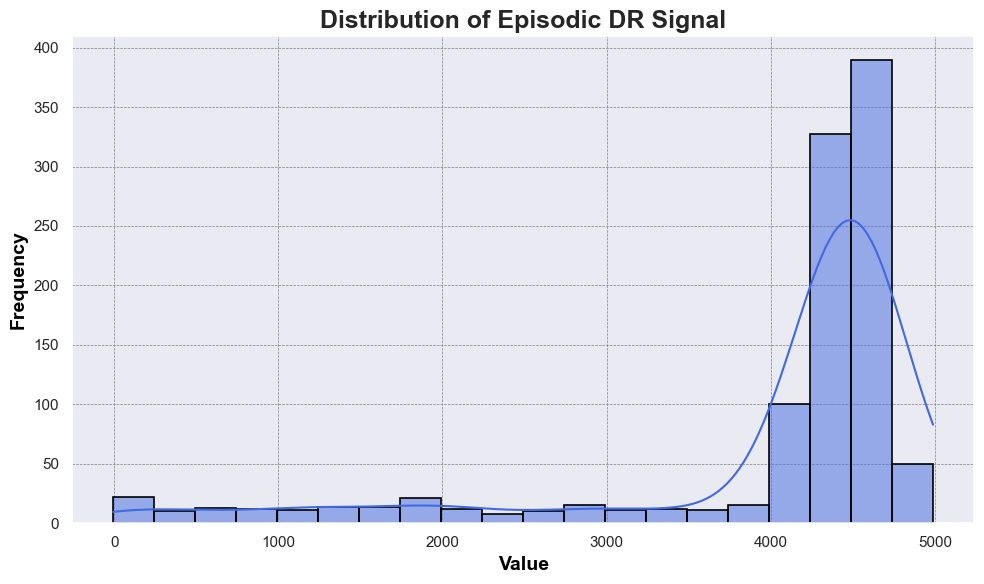

In [14]:
sns.set_theme(style="darkgrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the histogram with KDE
sns.histplot(episodic_dr_signal, bins=20, kde=True, color='royalblue', edgecolor='black', linewidth=1.2)

plt.title('Distribution of Episodic DR Signal', fontsize=18, weight='bold')
plt.xlabel('Value', fontsize=14, weight='bold', color='black')
plt.ylabel('Frequency', fontsize=14, weight='bold', color='black')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()

In [23]:
#this looks quite bad, and potentially requires exploration steps to ensure learning sub-optimal pathways as well
#to see how bad it is, lets check the distributions:
print("percentage of dr between 0 and 4000:", len([x for x in episodic_dr_signal if x < 4000]) / len(episodic_dr_signal))
print("percentage of dr between 4200 and 4800:", len([x for x in episodic_dr_signal if x > 4200 and x < 4800]) / len(episodic_dr_signal))

percentage of dr between 0 and 4000: 0.19851576994434136
percentage of dr between 4200 and 4800: 0.7226345083487941


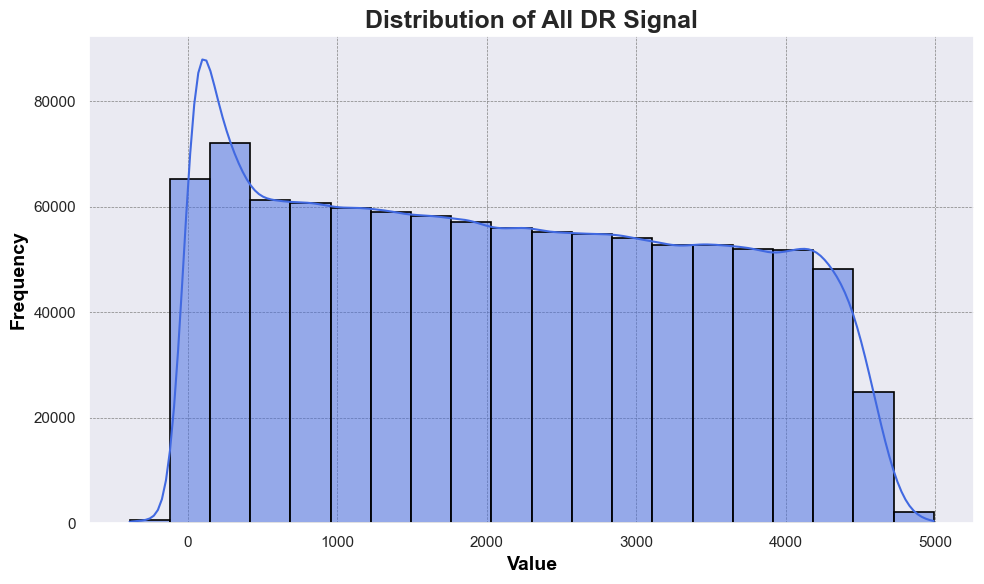

In [15]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))

# Plot the histogram with KDE of all Dr values
sns.histplot(all_rewards_to_go_list, bins=20, kde=True, color='royalblue', edgecolor='black', linewidth=1.2)

plt.title('Distribution of All DR Signal', fontsize=18, weight='bold')
plt.xlabel('Value', fontsize=14, weight='bold', color='black')
plt.ylabel('Frequency', fontsize=14, weight='bold', color='black')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()

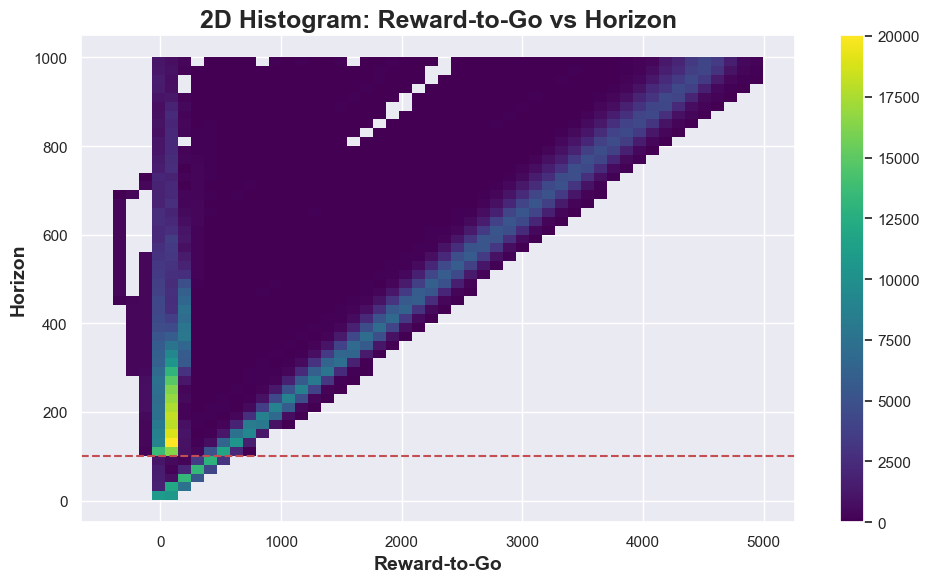

In [19]:
#make a 2d histogram of dr and dt to go to see how they are related

# Create a DataFrame from the two lists
#df = pd.DataFrame({"Reward-to-Go": all_rewards_to_go_list, "Horizon": all_time_to_go_list})
df = pd.DataFrame({"Reward-to-Go": all_rewards_to_go_aug, "Horizon": all_time_to_go_aug})

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))

# 2D histogram with bins
sns.histplot(data=df, x="Reward-to-Go", y="Horizon", bins=50, cmap="viridis", cbar=True)

plt.title("2D Histogram: Reward-to-Go vs Horizon", fontsize=18, weight="bold")
plt.axhline(y=min_horizon, color="r", linestyle="--", label="y = 2")
plt.xlabel("Reward-to-Go", fontsize=14, weight="bold")
plt.ylabel("Horizon", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


### Initial clustering state analysis, expanded in the "k_means_rewards.py" file

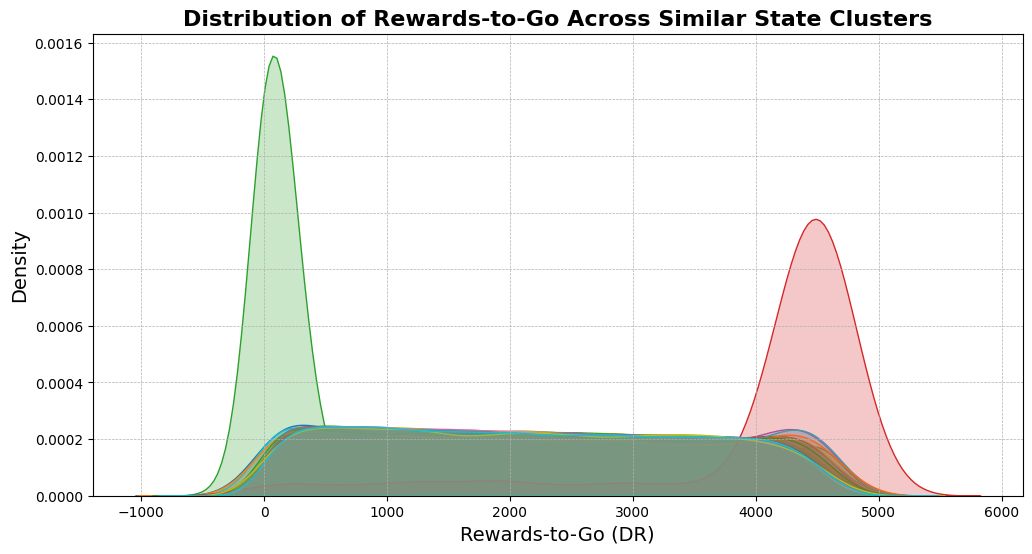

In [ ]:
from sklearn.cluster import KMeans

# Load the dataset
file_path = "../data/processed/concatenated_data.hdf5"
with h5py.File(file_path, "r") as f:
    observations = np.array(f["concatenated_data/observations"])
    rewards_to_go = np.array(f["concatenated_data/rewards_to_go"])


num_clusters = 30  # Adjust based on dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
state_clusters = kmeans.fit_predict(observations)

# Aggregate rewards-to-go for each cluster
clustered_dr = {i: [] for i in range(num_clusters)}
for idx, cluster in enumerate(state_clusters):
    clustered_dr[cluster].append(rewards_to_go[idx])

plt.figure(figsize=(12, 6))
for cluster_id, dr_values in clustered_dr.items():
    sns.kdeplot(dr_values, label=f"Cluster {cluster_id}", fill=True)

plt.xlabel("Rewards-to-Go (DR)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Distribution of Rewards-to-Go Across Similar State Clusters", fontsize=16, weight="bold")
#plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()
plt.savefig("rewards_to_go_per_cluster.png")

### Random Forest feature analysis, dropped due to mismatch with the trained network feature importance

Observations shape: (999382, 105) Rewards-to-Go shape: (999382,)


C:\Users\12saw\AppData\Local\Temp\ipykernel_26240\351367319.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_labels, palette="viridis")


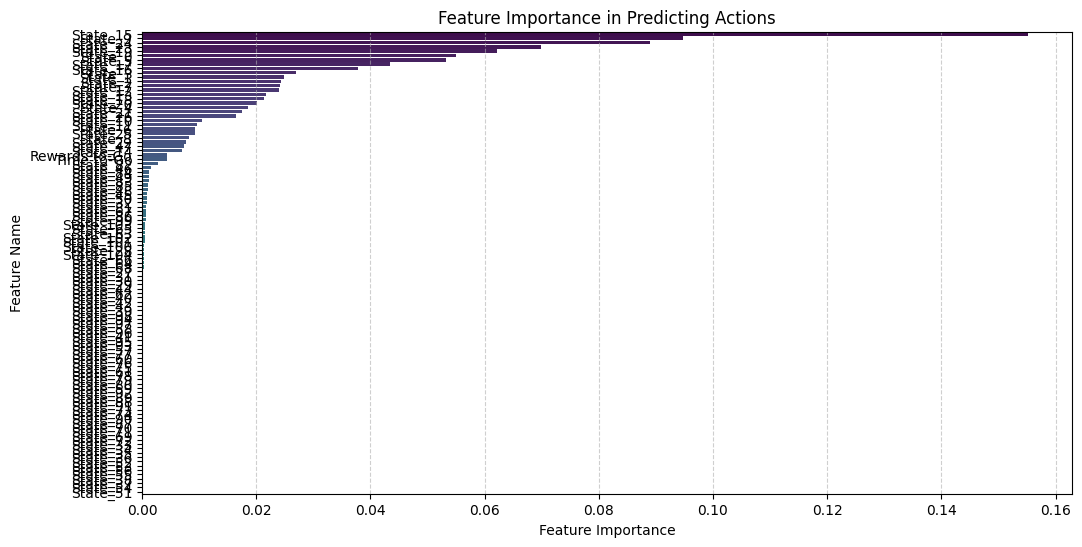

In [ ]:
# looks better, lets test for feature importances
from sklearn.ensemble import RandomForestRegressor

print(f"Observations shape: {all_observations.shape}", f"Rewards-to-Go shape: {all_rewards_to_go.shape}")
X = np.hstack((all_observations, all_rewards_to_go.reshape(-1, 1), all_time_to_go.reshape(-1, 1)))
y = all_actions 

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

In [ ]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create feature labels
num_state_vars = all_observations.shape[1]
feature_labels = [f"State_{i}" for i in range(num_state_vars)] + ["Rewards-to-Go", "Time-to-Go"]

# Sort features by importance (take only top 10)
sorted_indices = np.argsort(feature_importances)[::-1][:30]
sorted_importances = feature_importances[sorted_indices]
sorted_labels = [feature_labels[i] for i in sorted_indices]
colors = ['red' if label in ['Rewards-to-Go', 'Time-to-Go'] else 'royalblue' for label in sorted_labels]

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_importances, y=sorted_labels, palette="viridis", colors=colors)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Predicting Actions")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()
plt.savefig("feature_importance_random_forest.png")

NameError: name 'rf' is not defined